In [70]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

from skimage import measure, morphology
from skimage.color import label2rgb
from skimage.measure import regionprops

from PIL import Image

#from pdf2image import convert_from_bytes, convert_from_path

In [71]:
def show_image(img):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(img)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

In [72]:
def fileToImages(file_name):
    with open(file_name, 'rb') as file:
        pdf_test = file.read()
        images = convert_from_bytes(pdf_test)
        return images

In [73]:
def extract_sign(img, outlier_weight = 3, outlier_bias = 100, amplfier = 10, area_size = 10):
    condition = img > img.mean()
    labels = measure.label(condition, background=1)

    total_pixels = 0
    nb_region = 0
    average = 0.0
    for region in regionprops(labels):
        if (region.area > area_size):
            total_pixels += region.area
            nb_region += 1

    average = (total_pixels/nb_region)
    # small_size_outlier is used as a threshold value to remove pixels
    # are smaller than small_size_outlier
    small_size_outlier = average * outlier_weight + outlier_bias

    # big_size_outlier is used as a threshold value to remove pixels
    # are bigger than big_size_outlier
    big_size_outlier = small_size_outlier * amplfier

    # remove small pixels
    pre_version = morphology.remove_small_objects(labels, small_size_outlier)
    # remove the big pixels
    component_sizes = np.bincount(pre_version.ravel())
    too_small = component_sizes > (big_size_outlier)
    too_small_mask = too_small[pre_version]
    pre_version[too_small_mask] = 0
    
    labeled_mask = np.full(pre_version.shape, 255, dtype="uint8")
    labeled_mask = labeled_mask * (pre_version == 0)
    
    return labeled_mask

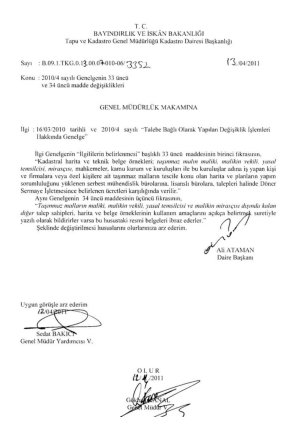

In [74]:
image = cv2.imread('./input/in1.jpg')
show_image(image)

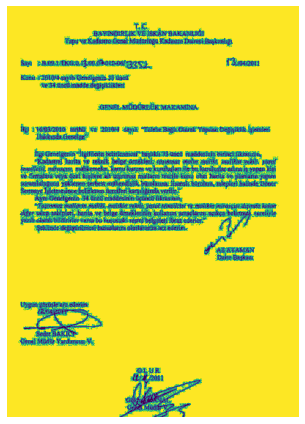

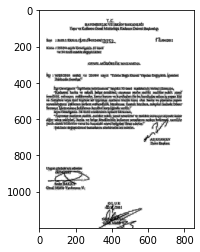

In [75]:
frame_HSV = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
frame_threshold = cv2.inRange(frame_HSV, (0, 0, 250), (255, 255, 255),)
show_image(frame_threshold)
plt.imshow(frame_threshold, "gray")

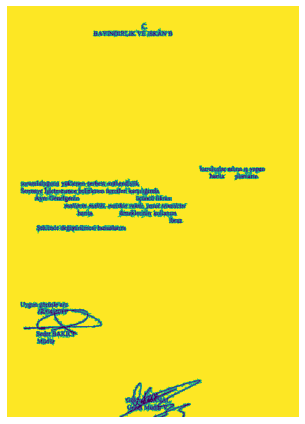

In [76]:
preview = extract_sign(frame_threshold)
show_image(preview)
plt.imsave('./output/ia.jpg', preview)

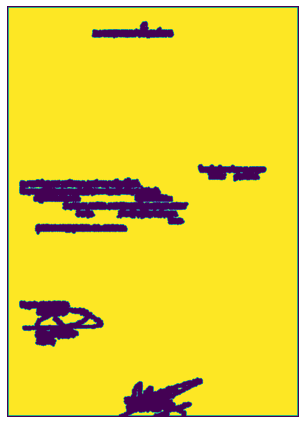

In [77]:
cnts, _ = cv2.findContours(preview, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# cnts[0]
cv2.drawContours(preview, cnts, -1, (0, 255, 0), 5)
show_image(preview)

#print(len(cnts))
#cnt = cnts[0] if len(cnts) == 2 else cnts[1]

#cv2.imshow("prev", preview)
#cv2.waitKey(3)

In [78]:
a=1000
a = 3 if False else 6

print(a)

6


[[337, 1146, 147, 54], [439, 1095, 120, 60], [47, 881, 231, 87], [140, 890, 94, 46]]


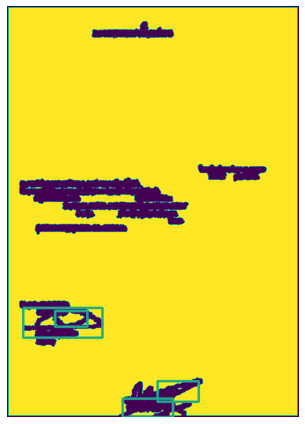

In [79]:
boxes = []
copy_img = preview.copy()
for c in cnts:
    (x, y, w, h) = cv2.boundingRect(c)
    if h * w > 4000 and h < copy_img.shape[0] and w < copy_img.shape[1]:
        if (w<4*h and h<4*w):
            cv2.rectangle(copy_img,(x,y),(x+w,y+h),(155,155,0),5)
            boxes.append([x, y, w, h])
print(boxes)
show_image(copy_img)
plt.imsave('./output/iab.jpg', copy_img)

In [80]:
np_boxes = np.array(boxes)
print(np_boxes)

[[ 337 1146  147   54]
 [ 439 1095  120   60]
 [  47  881  231   87]
 [ 140  890   94   46]]


In [81]:
area_size = list(map(lambda box: box[2] * box[3], np_boxes))
print(area_size)
area_size = np.array(area_size)
print(area_size)
area_dec_order = area_size.argsort()[::-1]
print(area_dec_order)
area_dec_order

[7938, 7200, 20097, 4324]
[ 7938  7200 20097  4324]
[2 0 1 3]


array([2, 0, 1, 3], dtype=int64)

In [82]:
sorted_boxes = np_boxes[area_dec_order]
print(sorted_boxes)

[[  47  881  231   87]
 [ 337 1146  147   54]
 [ 439 1095  120   60]
 [ 140  890   94   46]]


In [83]:
def is_intersected(box_a, box_b) -> bool:
    [x_a, y_a, w_a, h_a] = box_a    
    [x_b, y_b, w_b, h_b] = box_b
    
    if y_a > y_b + h_b: return False
    if y_a + h_a < y_b: return False
    if x_a > x_b + w_b: return False
    if x_a + w_a < x_b: return False
    return True

In [84]:
def merge_boxes(box_a, box_b) -> list:
    [x_a, y_a, w_a, h_a] = box_a    
    [x_b, y_b, w_b, h_b] = box_b
    
    min_x = min(x_a, x_b)
    min_y = min(y_a, y_b)
    max_w = max(w_a, w_b, (x_b + w_b - x_a), (x_a + w_a - x_b))
    max_h = max(h_a, h_b, (y_b + h_b - y_a), (y_a + h_a - y_b))
    
    return [min_x, min_y, max_w, max_h]

In [85]:
regions = {}
for i, box in enumerate(sorted_boxes):
    if len(regions) == 0:
        regions[0] = box
    else:
        is_merged = False
        print(regions.items())
        for key, region in regions.items():
            if is_intersected(region, box) == True:
                new_region = merge_boxes(region, box)
                regions[key] = new_region
                is_merged = True
                break
        if is_merged == False:
            key = len(regions)
            regions[key] = box

dict_items([(0, array([ 47, 881, 231,  87]))])
dict_items([(0, array([ 47, 881, 231,  87])), (1, array([ 337, 1146,  147,   54]))])
dict_items([(0, array([ 47, 881, 231,  87])), (1, [337, 1095, 222, 105])])


In [86]:

regions.values

<function dict.values>

In [87]:
def draw_regions(img, regions):
    cwd = os.getcwd() # chemin ou il existe le fichier
    print(cwd)
    for key, region in regions.items():
        copy_img = Image.fromarray(img)
        [x, y, w, h] = region
        
        crop = copy_img.crop((x, y, x + w, y + h))
        crop.save(cwd + './output/i_{}.jpeg'.format(key), 'JPEG')

In [88]:
draw_regions(preview, regions)

c:\Users\ASUS\Desktop\ProjetSignature\Version2\signatures
